In [2]:
# external imports
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

# internal imports
from process.data_module import CustomImageDataset, transforms
from process.model import CustomNeuralNetwork

In [3]:
training_data = CustomImageDataset("data/output/train.csv", "data/train/", transforms)
val_data = CustomImageDataset("data/output/val.csv", "data/val/", transforms)
test_data = CustomImageDataset("data/output/test.csv", "data/test/", transforms)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [4]:
model = CustomNeuralNetwork()
train_list, val_list = model.train_model(train_dataloader, val_dataloader, epochs=15, epoch_step=1)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


In [8]:
#TODO: rewrite these metrics based on  the output of our model

model.confusion_matrix

array([[1306,   35],
       [   5, 3870]])

Inital Test (5 epochs):

Time: 22 minutes

Baseline accuracy: 0.5032051282051282 (313/624)

Recall: 0.7083333333333334

Splits: 192 postive predictions (pneumonia), 432 negative predictions (normal)

In [6]:
train_losses, train_accuracies, train_recalls = train_list
val_losses, val_accuracies, val_recalls = val_list

print("train_losses: ", train_losses)
print("train_accuracies: ", train_accuracies)
print("train_recalls: ", train_recalls)

print("val_losses: ", val_losses)
print("train_accuracies: ", val_accuracies)
print("val_recalls: ", val_recalls)

train_losses:  [0.30065682975620756, 0.24651414128701862, 0.17771756081137716, 0.15636538541535053, 0.10940450366313864, 0.09466524248397569, 0.06221734055476945, 0.057469665805423044, 0.08387218277458465, 0.04886196016493004, 0.04911814055621352, 0.04608139631383848, 0.03368747568825578, 0.03236793590391555, 0.032142275262896605]
train_accuracies:  [0.8755751533742331, 0.9072085889570553, 0.9403757668711656, 0.9488113496932515, 0.9683665644171779, 0.9710506134969326, 0.9842791411042945, 0.9848542944785276, 0.9756518404907976, 0.9877300613496932, 0.9861963190184049, 0.9894555214723927, 0.9927147239263804, 0.9923312883435583, 0.9923312883435583]
train_recalls:  [0.7099179716629381, 0.8337061894108874, 0.901565995525727, 0.9097688292319165, 0.947800149142431, 0.9500372856077554, 0.9634601043997018, 0.9619686800894854, 0.9351230425055929, 0.9671886651752424, 0.9604772557792692, 0.9701715137956749, 0.9739000745712155, 0.9739000745712155, 0.9739000745712155]
val_losses:  [4.130391597747803,

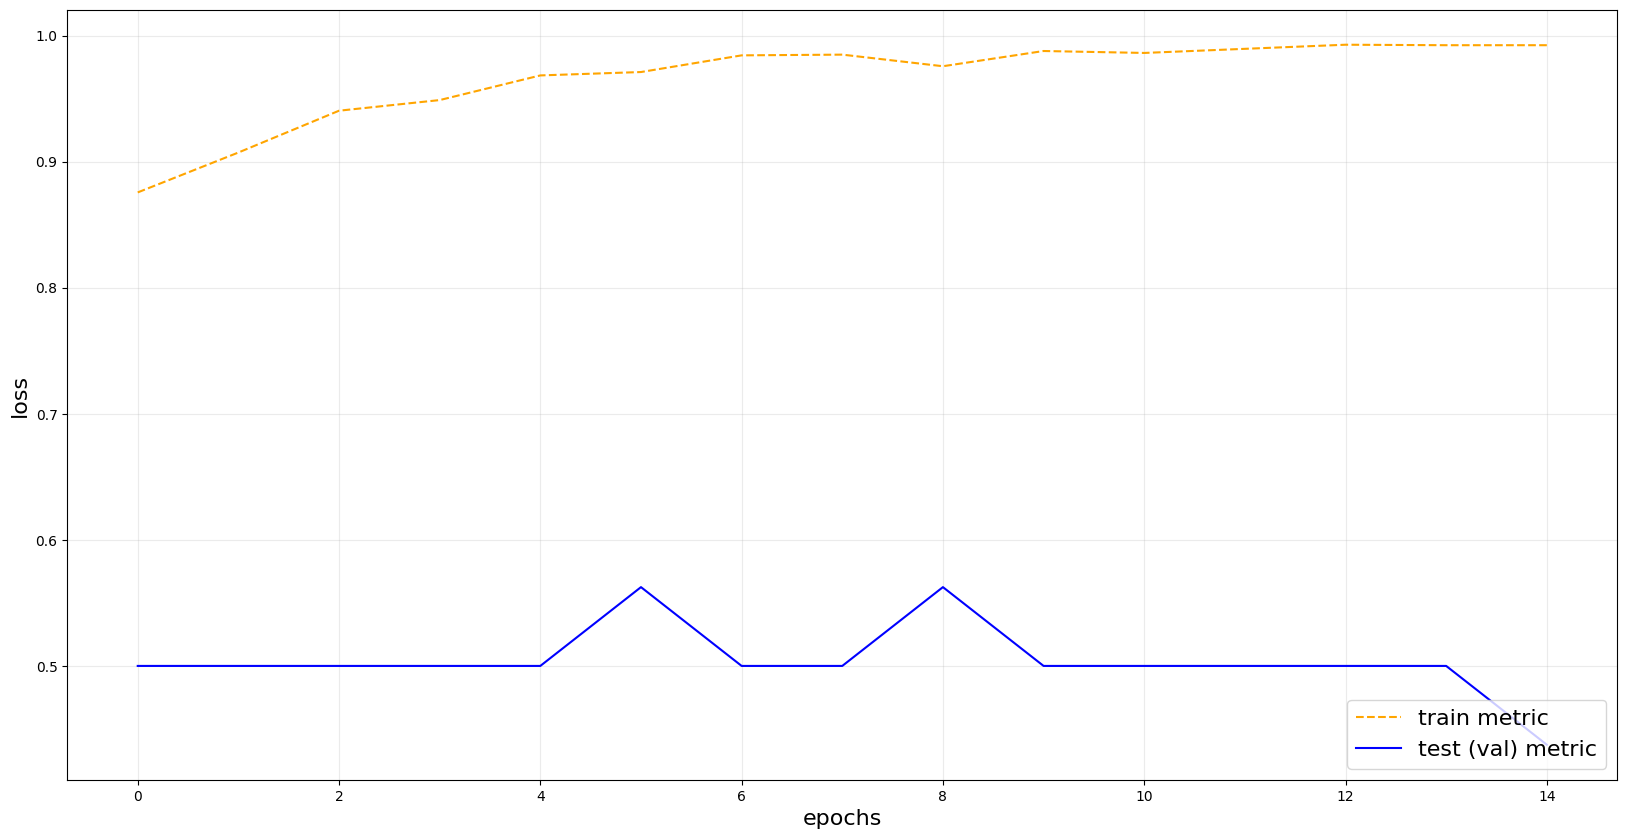

In [10]:
#TODO: edit this method in model.py 
model.create_graph(15, 1, train_recalls, val_recalls)

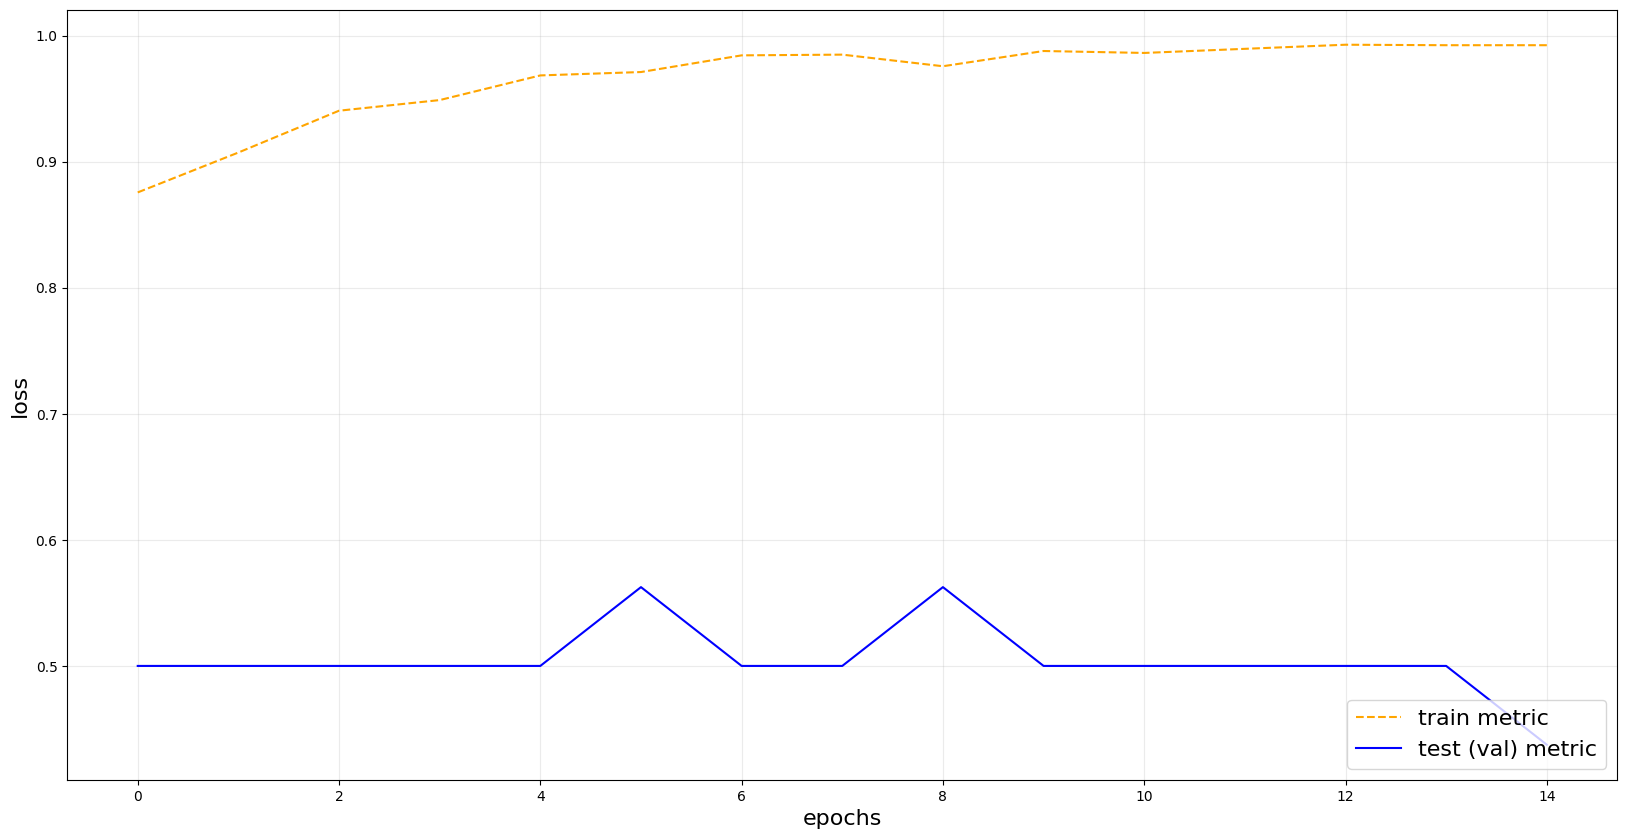

In [11]:
#TODO: edit this method in model.py 
model.create_graph(15, 1, train_accuracies, val_accuracies)

In [ ]:
model2 = CustomNeuralNetwork()
train_list, val_list = model.train_model(train_dataloader, val_dataloader, epochs=15, epoch_step=1)

Test 2: Smaller images size (256, 256); 15 epochs

Train Acc Range (epoch 0 - 14): 0.8500766871165644 - 0.9806365030674846

Last Train Recall Range: 0.717509727626459 - 0.9711246200607903

Test Acc: 0.625

Test recall: 0.00 ???

In [ ]:
# testing sklearn recall 
from sklearn.metrics import recall_score

y_pred = torch.tensor([1, 0, 1, 0])
y_true = torch.tensor([1, 0, 0, 0])

recall_score(y_true, y_pred)
y_true = torch.cat((y_pred, y_true))